# NGBoost

NGBoost (Natural Gradient Boosting) is a method for probabilistic regression that extends gradient boosting to predict full probability distributions instead of just point estimates.

**Key Ideas**

- Models the full probability distribution of the target variable, not just a single value.
- For instance, when modeling a normal distribution, NGBoost predicts both the loc (μ) and scale (σ) of the distribution as a target.
- Uses the Natural Gradient to optimize.
- Gradient boosting is a supervised learning method that builds an ensemble of weak learners in a sequential training process.
- NGBoost package: Can be used with any base learner and custom family of distributions with continuous parameters.

**Model documentation**: 

- introduction: https://stanfordmlgroup.github.io/projects/ngboost/
- paper: https://arxiv.org/pdf/1910.03225
- github: https://github.com/stanfordmlgroup/ngboost
- user guide: https://stanfordmlgroup.github.io/ngboost/intro.html
- **guide to add new distribution target and scoring**: https://stanfordmlgroup.github.io/ngboost/5-dev.html

**Requirements:**

!pip install ngboost

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            }
}
```
![proba_forecast_v2](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v2.png?raw=true)

In [1]:
import os
import pandas as pd
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt

TEST_DATA_START_TIME = 90000

current_dir = Path.cwd()
PATH_DATA = current_dir.parent.parent.parent / 'data' / 'bird_feed_data.csv'

def local_test_data_generator(path_data=PATH_DATA, chunksize=1000, start_time=TEST_DATA_START_TIME):
    """
    Generate the local test data yielding one record (dict) at a time.

    :param path_data: path to .csv data file
    :param chunksize: Number of rows to read at a time (default is 1000).
    """
    prev_time = start_time
    for chunk in pd.read_csv(path_data, chunksize=chunksize):
        for k, row in chunk.iterrows():
            if k > 500:
                row['time'] = row['time'] / math.pi  # don't ask
                if row['time'] > prev_time:
                    prev_time = row['time']
                    yield row.to_dict()


def remote_test_data_generator(chunksize=1000, start_time=TEST_DATA_START_TIME):
    """
    Generate the remote test data yielding one record (dict) at a time.

    :param chunksize: Number of rows to read at a time (default is 1000).
    """
    url = 'https://raw.githubusercontent.com/microprediction/birdgame/refs/heads/main/data/bird_feed_data.csv'
    prev_time = start_time
    for chunk in pd.read_csv(url, chunksize=chunksize):
        for k, row in chunk.iterrows():
            if k > 500:
                row['time'] = row['time'] / math.pi  # don't ask
                if row['time'] > prev_time:
                    prev_time = row['time']
                    yield row.to_dict()

### Warm up example

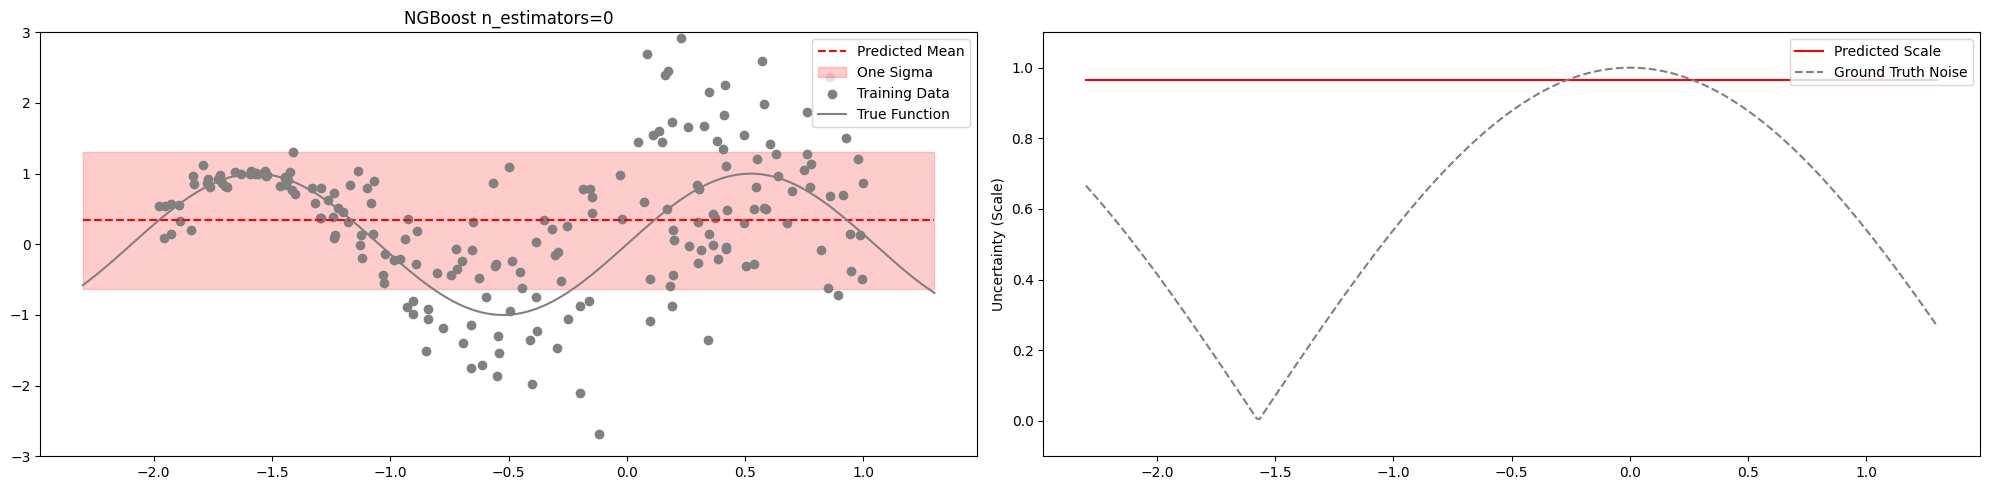

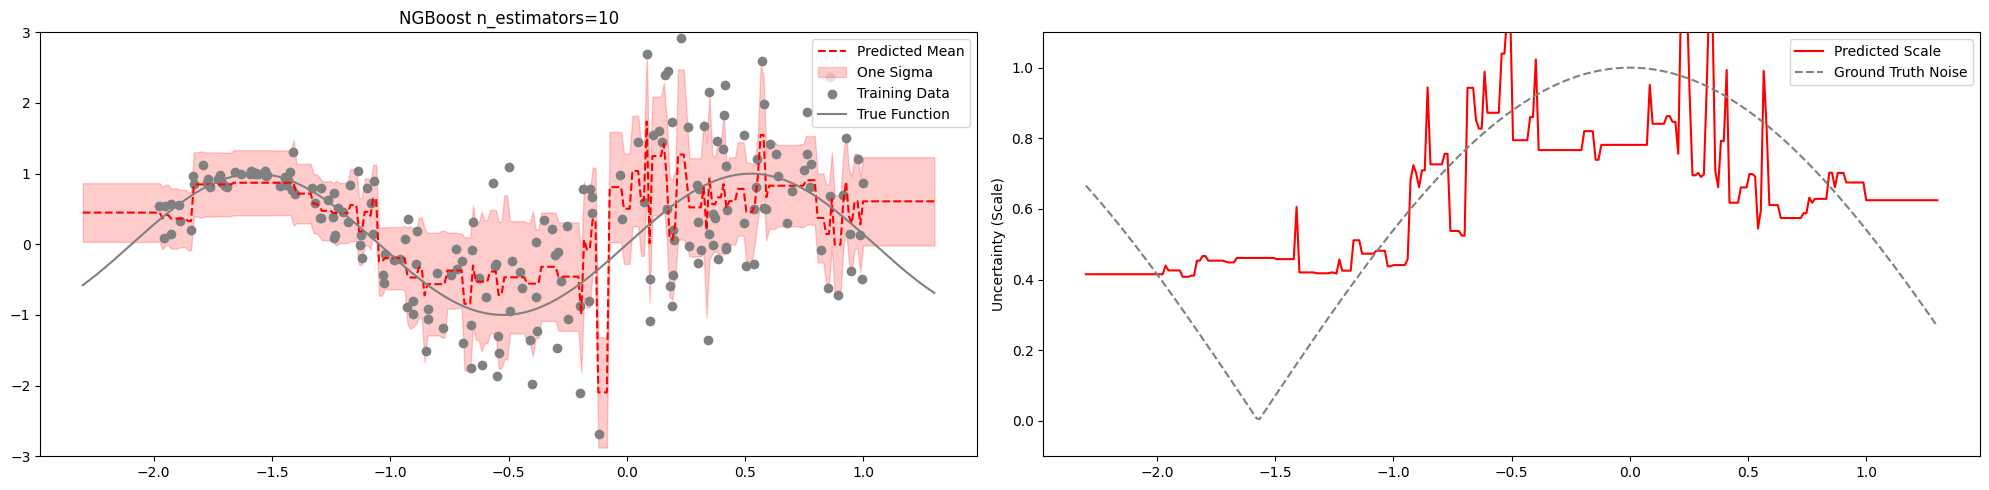

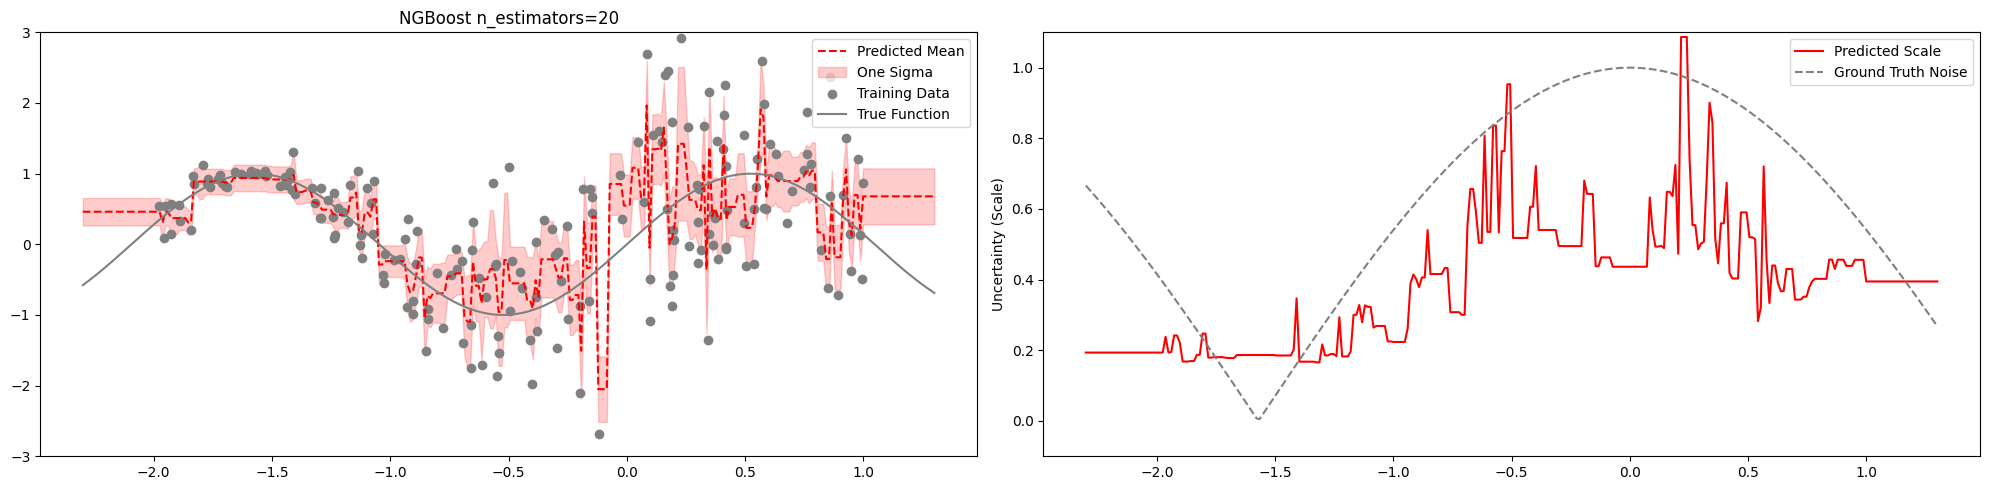

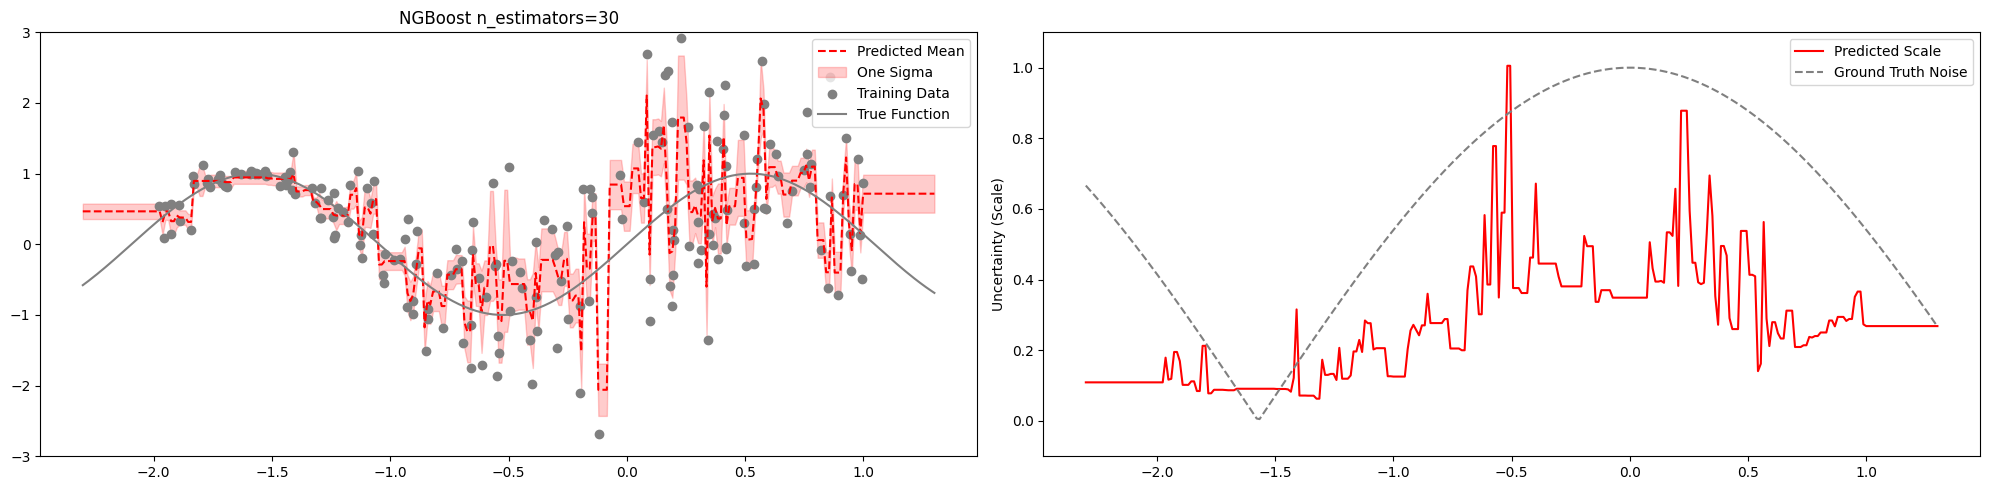

In [2]:
from ngboost import NGBoost
from sklearn.tree import DecisionTreeRegressor
from ngboost.distns import Normal

# True function and noise
def true_function(X):
    return np.sin(3 * X)

def true_noise_scale(X):
    return np.abs(np.cos(X))

def visualize_ngboost(max_n_estimators=40, step=10, n_data_samples=200):
    """ Function to visualize NGBoost with different number of estimators. """

    # Create synthetic data
    np.random.seed(71)
    X = np.random.uniform(-2, 1, n_data_samples)
    y = true_function(X) + np.random.normal(scale=true_noise_scale(X), size=n_data_samples)

    # Pace points for plotting
    xx = np.linspace(-2.3, 1.3, 300).reshape(-1, 1)

    for i, n in enumerate(range(0, max_n_estimators, step)):
        # NGBoost model
        model = NGBoost(Dist=Normal, learning_rate=0.1, n_estimators=n, natural_gradient=True,
                        verbose=False, random_state=15,
                        validation_fraction=0.1, early_stopping_rounds=None,
                        Base=DecisionTreeRegressor(max_depth=5))
        model.fit(X.reshape(-1, 1), y)

        y_pred_dist = model.pred_dist(xx)

        # Extract the loc and scale of the predictions for each sample
        loc = y_pred_dist.loc
        scale = y_pred_dist.scale
        
        fig, axes = plt.subplots(figsize=(20, 5), nrows=1, ncols=2, sharex=True)
        
        # Plot mean and confidence interval
        ax = axes[0]
        ax.plot(xx, loc, '--', label='Predicted Mean', c='red')
        ax.fill_between(xx.flatten(), loc.flatten() - scale.flatten(), loc.flatten() + scale.flatten(), color='red', label='One Sigma', alpha=0.2)
        
        # Scatter plot of training data and true function
        ax.scatter(X, y, label='Training Data', c='gray')
        ax.plot(xx, true_function(xx), c='gray', label='True Function')
        ax.set_ylim(-3, 3)
        ax.legend(loc=1)
        ax.set_title(f'NGBoost n_estimators={n}')
        
        # Plot uncertainty (scale)
        ax = axes[1]
        ax.set_ylabel('Uncertainty (Scale)')
        ax.plot(xx, scale, label='Predicted Scale', c='red')
        ax.plot(xx, true_noise_scale(xx), '--', label='Ground Truth Noise', c='gray')
        ax.set_ylim(-0.1, np.max(true_noise_scale(xx)) + 0.1)
        ax.legend(loc=1)
        
        fig.tight_layout()
        plt.show()

# Run NGBoost for different number of estimators
visualize_ngboost(max_n_estimators=40, step=10, n_data_samples=200)

In [3]:
import numpy as np
from ngboost import NGBoost
from ngboost.distns import Normal
from sklearn.tree import DecisionTreeRegressor


class TrackerBase:
    """
    Base class that handles quarantining of data points before they are eligible for processing.
    """
    def __init__(self, horizon: int):
        self.horizon = horizon
        self.quarantine = []
        self.count = 0

    def add_to_quarantine(self, time, value):
        """ Adds a new value to the quarantine list. """
        self.quarantine.append((time + self.horizon, value))

    def pop_from_quarantine(self, current_time):
        """ Returns the most recent valid data point from quarantine. """
        valid = [(j, (ti, xi)) for (j, (ti, xi)) in enumerate(self.quarantine) if ti <= current_time]
        if valid:
            prev_ndx, (prev_t, prev_x) = valid[-1]
            self.quarantine = self.quarantine[prev_ndx+1:]  # Trim the quarantine list
            return prev_t, prev_x
        return None, None
    

class NGBoostTracker(TrackerBase):
    """
    A model that tracks the dove location using NGBoost.

    Parameters
    ----------
    horizon : int
        The "look-ahead" in time after which the recorded data becomes valid for updating.
    train_model_frequency : int
        The frequency at which the NGBoost model will be retrained based on the count of observations 
        ingested. This determines how often the model will be updated with new data.
    num_data_points_max : int
        The maximum number of data points to use for training the NGBoost model.
    window_size : int
        The number of previous data points (the sliding window size) used to predict the future value 
        at the horizon. It defines how many past observations are considered for prediction.
    """
    def __init__(self, horizon=10, train_model_frequency=100, num_data_points_max=1000, window_size=5):
        super().__init__(horizon)
        self.current_x = None
        self.last_observed_data = [] # Holds the last few observed data points
        self.x_y_data = [] # Holds pairs of previous and current data points

        self.train_model_frequency = train_model_frequency
        self.num_data_points_max = num_data_points_max # (X.shape[0])
        self.window_size = window_size # (X.shape[1])

        # Initialize the NGBoost model
        self.model = NGBoost(Dist=Normal, learning_rate=0.1, n_estimators=50, natural_gradient=True, verbose=False, random_state=15,
                             validation_fraction=0.1, early_stopping_rounds=None,
                             Base=DecisionTreeRegressor(
                                    criterion="friedman_mse",
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_depth=5,
                                    splitter="best",
                                    random_state=None,
                                ))

    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the
        estimated Gaussian mixture model.

        The core distribution captures regular variance, while the tail distribution
        captures extreme deviations.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """
        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.last_observed_data.append(x)
        self.current_x = x
        prev_t, prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:
            self.x_y_data.append((prev_x, x))

            if self.count > self.window_size and self.count%self.train_model_frequency == 0:
                
                x_y_data = np.array(self.x_y_data)
                xi_values = x_y_data[:, 0]
                yi_values = x_y_data[:, 1]

                # Determine the number of data points to use for training
                num_data_points = min(len(xi_values), self.num_data_points_max)
                if len(xi_values) < self.num_data_points_max + self.window_size:
                    num_data_points = num_data_points - (self.window_size + 3)

                # Construct 'X' with fixed-size slices and 'y' as the values to predict
                X = np.lib.stride_tricks.sliding_window_view(xi_values[-(num_data_points + self.window_size - 1):], self.window_size)
                y = yi_values[-num_data_points:]

                # Fit a single NGBoost model (since we only need one model)
                self.model.fit(X, y)

                # Keep only latest data
                self.x_y_data = self.x_y_data[-(self.num_data_points_max + self.window_size * 2):]
                self.last_observed_data = self.last_observed_data[-(self.window_size+1):]
            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a Gaussian distribution.
        """
        x_mean = self.current_x
        components = []

        try:
            X_input = np.array([self.last_observed_data[-(self.window_size+1):]])

            # Get the predicted distribution
            y_test_ngb = self.model.pred_dist(X_input)

            # here we use current value as loc but you can get the parameter loc from ngboost normal distribution class: y_test_ngb.loc[0]
            loc = x_mean 

            scale = y_test_ngb.scale[0] # get the parameter scale from ngboost normal distribution class
            scale = max(scale, 1e-6)
        except:
            loc = x_mean
            scale = 1e-6

        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale}
            },
            "weight": 1
        }

        prediction_density = {
            "type": "mixture",
            "components": [components]
        }

        return prediction_density


In [4]:
import typing


def train():
    pass


def infer(
    payload_stream: typing.Iterator[dict],
):
    # Parameters
    HORIZON = 10
    TRAIN_MODEL_FREQUENCY=100
    NUM_DATA_POINTS_MAX=1000
    WINDOW_SIZE = 5

    # Initialize Model
    model = NGBoostTracker(horizon=HORIZON, train_model_frequency=TRAIN_MODEL_FREQUENCY, 
                           num_data_points_max=NUM_DATA_POINTS_MAX, window_size=WINDOW_SIZE)

    yield  # Signal initialization completion

    for payload in payload_stream:
        model.tick(payload)
        yield model.predict()

In [5]:
def compute_pdf_score(past_pdf, observed_dove_location):
    """ Compute weighted PDF score of a normal distribution """
    weighted_pdf_score = 0
    highest_weight = 0
    stored_predictions = []

    for component in past_pdf.get('components', []):
        density = component['density']
        loc, scale, weight = density['params']['loc'], density['params']['scale'], component['weight']

        # Compute PDF score (Gaussian)
        pdf_score = (1 / (math.sqrt(2 * math.pi * scale**2))) * \
                    math.exp(-((observed_dove_location - loc) ** 2) / (2 * scale**2))

        weighted_pdf_score += weight * pdf_score

        # Store prediction with highest weight
        if weight > highest_weight:
            stored_predictions = [(loc, scale, observed_dove_location, pdf_score)]
            highest_weight = weight

    return round(weighted_pdf_score, 3), stored_predictions


def find_past_pdf(pdf_history, current_time, horizon):
    """ Function to find the most recent valid past prediction """
    for past_time, p_pdf in reversed(pdf_history):
        if past_time < current_time - horizon:
            return p_pdf
    return None  # No valid past prediction

In [6]:
import time
import json
from tqdm.auto import tqdm

# Parameters
HORIZON = 10
TRAIN_MODEL_FREQUENCY=100
NUM_DATA_POINTS_MAX=1000
WINDOW_SIZE = 5
MAX_TRACKER_COUNT = 10000
SHOW_PRINT = True
STEP_PRINT = 1000

# Initialize Tracker
tracker = NGBoostTracker(horizon=HORIZON, train_model_frequency=TRAIN_MODEL_FREQUENCY, 
                         num_data_points_max=NUM_DATA_POINTS_MAX, window_size=WINDOW_SIZE)

# History to track evaluation metrics and the PDFs
pdf_score_history = []
pdf_history = []
store_pred = []

# Start Processing Data
start_time = time.time()
if os.path.exists(PATH_DATA):
    data_generator = local_test_data_generator()
else:
    data_generator = remote_test_data_generator()

for payload in tqdm(data_generator, position=0, leave=True):
    try:
        tracker.tick(payload)
        pdf = tracker.predict()
        current_time = payload['time']

        # Store the latest PDF prediction
        pdf_history.append((current_time, pdf))

        # Find past PDF predicition for evaluation
        past_pdf = find_past_pdf(pdf_history, current_time, HORIZON)

        if past_pdf:
            observed_dove_location = payload['dove_location']
            weighted_pdf_score, predictions = compute_pdf_score(past_pdf, observed_dove_location)

            # Store results
            pdf_score_history.append(weighted_pdf_score)
            store_pred.extend([(current_time, *p) for p in predictions])

            if SHOW_PRINT and len(pdf_history) % STEP_PRINT == 0:
                print(
                    f"[{tracker.count}] PDF Score: {weighted_pdf_score:.4f} / true: {observed_dove_location:.4f} / "
                    f"pred: {predictions[0][0]:.4f} / dif: {observed_dove_location - predictions[0][0]:.4f} / "
                    f"scale: {predictions[0][1]:.4f}"
                )
        else:
            if SHOW_PRINT:
                print(f"[{tracker.count}] No valid past PDF for evaluation.")

    except json.JSONDecodeError:
        print(f"[{tracker.count}] Error: Could not parse JSON payload.")

    if tracker.count > MAX_TRACKER_COUNT:
        break

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.2f} seconds")

0it [00:00, ?it/s]

[0] No valid past PDF for evaluation.
[0] No valid past PDF for evaluation.
[523] PDF Score: 0.0000 / true: 8396.0902 / pred: 8396.1007 / dif: -0.0105 / scale: 0.0019
[1065] PDF Score: 32.1240 / true: 8395.4667 / pred: 8395.4600 / dif: 0.0068 / scale: 0.0050
[1597] PDF Score: 56.9680 / true: 8395.8812 / pred: 8395.8787 / dif: 0.0025 / scale: 0.0065
[2114] PDF Score: 22.5720 / true: 8395.0469 / pred: 8395.0548 / dif: -0.0079 / scale: 0.0050
[2630] PDF Score: 59.9400 / true: 8395.6477 / pred: 8395.6440 / dif: 0.0037 / scale: 0.0051
[3140] PDF Score: 0.0000 / true: 8395.7813 / pred: 8395.7502 / dif: 0.0311 / scale: 0.0025
[3692] PDF Score: 54.6760 / true: 8395.7586 / pred: 8395.7586 / dif: 0.0000 / scale: 0.0073
[4234] PDF Score: 51.6860 / true: 8395.0275 / pred: 8395.0296 / dif: -0.0021 / scale: 0.0074
[4726] PDF Score: 0.0000 / true: 8394.8244 / pred: 8394.9810 / dif: -0.1566 / scale: 0.0078
[5319] PDF Score: 32.8280 / true: 8395.1889 / pred: 8395.1937 / dif: -0.0048 / scale: 0.0111
[58

In [7]:
def compute_metric_stats(df):
    """Compute and print median, mean and std of metrics"""
    stats = df.agg(["median", "mean", "std"]).round(3)
    
    for stat_name, values in stats.iterrows():
        print(f"{stat_name.capitalize()}: {values.to_dict()}")

    return stats

skip_length = 500
# Create history score (skipping first 500 values -> skip warmup of model)
scores = pd.DataFrame({"pdf_score": pdf_score_history[skip_length:]})
stats_summary = compute_metric_stats(scores)

pred_summary = pd.DataFrame(store_pred[skip_length:], columns=["time", "loc", "scale", "dove_location", "pdf_score"])
pred_summary.round(4)

Median: {'pdf_score': 32.466}
Mean: {'pdf_score': 35.75}
Std: {'pdf_score': 36.039}


,time,loc,scale,dove_location,pdf_score
0,102671.0,8396.5263,0.0006,8396.5300,0.0000
1,102672.0,8396.5311,0.0006,8396.5121,0.0000
2,102674.0,8396.5311,0.0006,8396.5121,0.0000
3,102685.0,8396.5121,0.0006,8396.5139,6.7963
4,102686.0,8396.5121,0.0006,8396.5285,0.0000
...,...,...,...,...,...
18640,289588.0,8396.0612,0.0032,8396.0507,0.6635
18641,289590.0,8396.0612,0.0032,8396.0479,0.0284
18642,289592.0,8396.0612,0.0032,8396.0450,0.0005
18643,289595.0,8396.0612,0.0032,8396.0431,0.0000


In [8]:
def plot_dove_predictions(store_pred, start_ind=1000, window_size=200, max_pdf_score=100):
    """
    Plots observed vs. predicted dove locations with uncertainty and PDF scores.

    Parameters:
        store_pred (list of tuples): Stored predictions in the format (time, loc, scale, dove_location, pdf_score).
        start_ind (int): Starting index for slicing data.
        window_size (int): Number of points to plot.
        max_pdf_score (float): Maximum value for clipping PDF scores (to prevent extreme values from dominating).
    """
    end_ind = start_ind + window_size
    
    # time, dove_location, predictions and metrics
    data_slice = np.array(store_pred[start_ind:end_ind], dtype=np.float64)
    times, predicted_locs, scales, dove_location, pdf_scores = data_slice.T

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot locations (left y-axis)
    ax1.scatter(times, dove_location, color="grey", label="Observed Dove Location", marker="o", alpha=0.9)
    ax1.plot(times, predicted_locs, label="Predicted Mean (loc)", color="red", linestyle="-")
    ax1.fill_between(times, predicted_locs - scales, predicted_locs + scales, color="red", alpha=0.2, label="±1 Std Dev (Scale)")

    # Left y-axis labels
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Dove Location")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # Create second right y-axis for metric scores
    ax2 = ax1.twinx()
    ax2.scatter(times, np.clip(pdf_scores, 0, max_pdf_score), label="PDF Scores", color="green", marker="|", alpha=0.2)

    # Right y-axis labels
    ax2.set_ylabel("PDF Score")
    ax2.legend(loc="upper right")

    plt.title("Observed vs. Predicted Dove Location with Uncertainty and PDF Scores")
    plt.show()


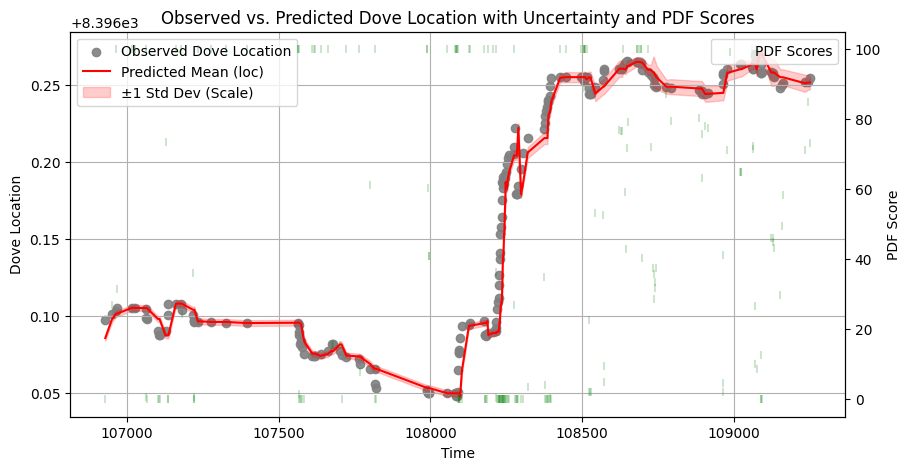

In [9]:
start_ind=1000
window_size=200
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)

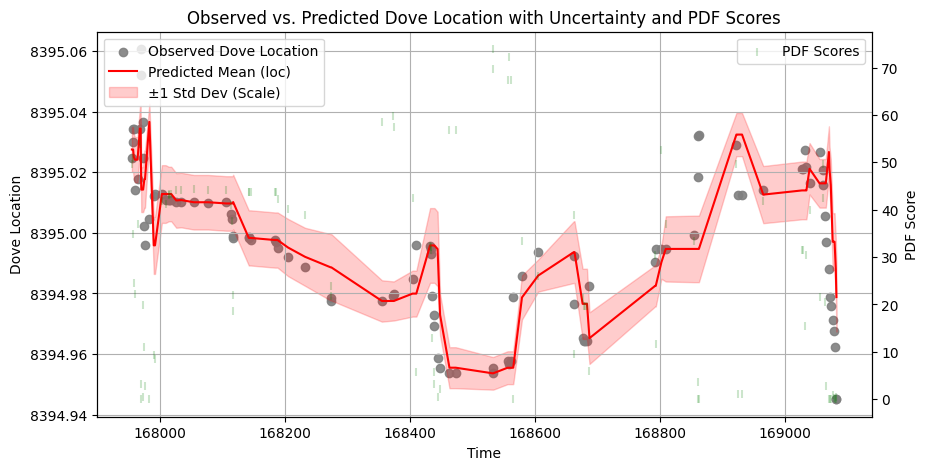

In [10]:
start_ind=8000
window_size=100
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)